# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо провести исследовательский анализ данных и построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста. Созданную модель нужно проанализировать.

**Содержание**<a id='toc0_'></a>    
- 1. [Исследовательский анализ данных](#toc1_)    
- 2. [Обучение модели](#toc2_)    
- 3. [Анализ обученной модели](#toc3_)    
- 4. [Чек-лист](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Исследовательский анализ данных](#toc0_)

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Первоначально загрузим датасет

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.shape

(7591, 2)

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Датасет включает в себя более 7000 изображений, пропусков в данных нет

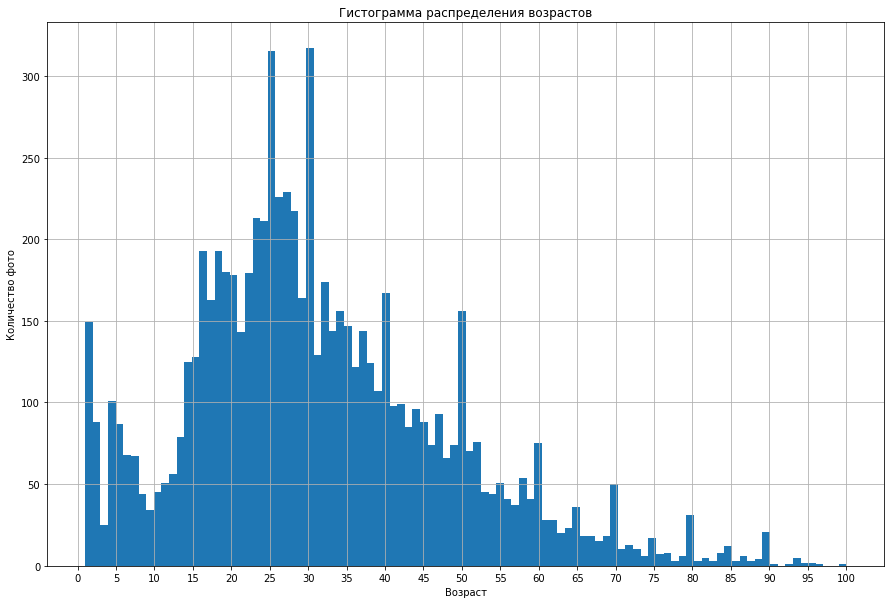

In [6]:
fig, ax = plt.subplots()
ax.set(title='Гистограмма распределения возрастов', xlabel='Возраст', ylabel='Количество фото', xticks=list(range(0, 105, 5)))
labels.real_age.hist(bins=100, figsize=(15, 10));

Наиболее частая возрастная категория - 20-25 лет. Возраст людей на многих фото округлён.

Теперь подготовим данные для обучения нейросети

In [7]:
datagen = ImageDataGenerator(rescale=1/255.)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=42
)

Found 7591 validated image filenames.


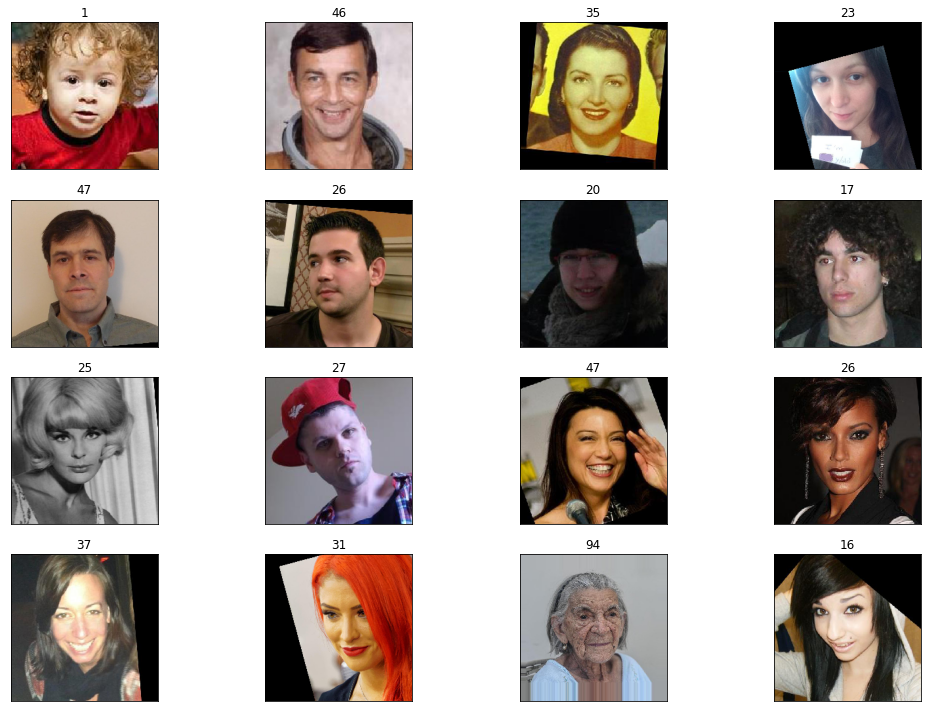

In [8]:
fig = plt.figure(figsize=(15, 10))
features, target = next(datagen_flow)
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.imshow(features[i])
    plt.title(target[i])

Данные подготовлены, метки к фотографиям выставлены корректно.

Фото ориентированы так, что лицо человека располагается вертикально, т.е. фото предварительно обработаны. Поэтому повороты следует выполнять только в качестве аугментаций.

Большинство фотографий цветные, при этом есть и чёрно-белые. Кроме того они имеют одинаковый размер.

## 2. <a id='toc2_'></a>[Обучение модели](#toc0_)

Код обучения модели и её результат вывода на экран.

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen_train = ImageDataGenerator(rescale=1/255., validation_split=0.25,
                                       horizontal_flip=True, rotation_range=20,
                                       width_shift_range=0.2, height_shift_range=0.2)
    
    datagen_flow = datagen_train.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        subset='training',
        batch_size=32,
        seed=42
    )
    return datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen_train = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    
    datagen_flow = datagen_train.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        subset='validation',
        batch_size=32,
        seed=42
    )
    return datagen_flow


def create_model(input_shape):
    adam = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=adam,
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-04-21 15:18:33.108334: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-21 15:18:33.486287: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 100s - loss: 279.6720 - mae: 12.3445 - val_loss: 610.0970 - val_mae: 19.5919
Epoch 2/10
178/178 - 95s - loss: 130.8047 - mae: 8.6430 - val_loss: 633.1635 - val_mae: 20.0731
Epoch 3/10
178/178 - 94s - loss: 109.3599 - mae: 7.9363 - val_loss: 359.4434 - val_mae: 13.9067
Epoch 4/10
178/178 - 94s - loss: 101.1265 - mae: 7.6375 - val_loss: 151.2787 - val_mae: 9.2857
Epoch 5/10
178/178 - 94s - loss: 90.5720 - mae: 7.2494 - val_loss: 111.2530 - val_mae: 7.8552
Epoch 6/10
178/178 - 92s - loss: 82.0148 - mae: 6.8931 - val_loss: 101.9030 - val_mae: 7.5983
Epoch 7/10
178/178 - 91s - loss: 76.9442 - mae: 6.6580 - val_loss: 102.4265 - val_mae: 7.7984
Epoch 8/10
178/178 - 95s - loss: 71.4093 - mae: 6.4653 - val_loss: 132.6134 - val_mae: 8.6259
Epoch 9/10
178/178 - 95s - loss: 67.0084 - mae: 6.2301 - val_loss: 100.3785 - val_mae: 7.6150
Epoch 10/10
178/178 - 92s - loss: 63.1109 - mae: 6.0554 - val_loss: 92.5416 - val_mae: 7.1312
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 92.5416 - mae: 7.1312
Test MAE: 7.1312


```

## 3. <a id='toc3_'></a>[Анализ обученной модели](#toc0_)

- Данной модели удалось достичь требуемого качества в указанной метрике: МАЕ < 8
- Выбрана архитектура ResNet50 с функцией активации ReLU в последнем слое
- На обучающей выборке применялась аугментация данных: сдвиги по высоте и ширине, горизонтальные отражения, повороты до 20 градусов.
- Гиперпараметры модели: 10 эпох, шаг обучения = 0.0001, функция потерь - MSE, оптимизатор - Adam
- Склонности к переобучению не выявлено

## 4. <a id='toc4_'></a>[Чек-лист](#toc0_)

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы